# Test Sentiment Analysis

In [9]:
import datetime
import copy as c
import random
import collections
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
#!pip install afinn
from afinn import Afinn
#!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

In [10]:
#On récupère directement le dataset nettoyé
url_local=r"C:\Users\Antoine\Downloads\clean_ecb_speeches_dataset.csv"
df=pd.read_csv(url_local,sep = ",",encoding='utf-8')

In [11]:
df

,date,speakers,title,subtitle,contents,Year,Month,Day,DayofWeek,DayofWeek_str,Month_str
0,2021-11-29,Christine Lagarde,Dialogue in a changing world,"Lectio Magistralis by Christine Lagarde, Presi...",SPEECH Dialogue in a changing world Lect...,2021,11,29,1,Monday,November
1,2021-11-26,Christine Lagarde,Change and continuity in law,"Keynote speech by Christine Lagarde, President...",SPEECH Change and continuity in law Keyn...,2021,11,26,5,Friday,November
2,2021-11-25,Frank Elderson,When you need change to preserve continuity: c...,"Speech by Frank Elderson, Member of the Execut...",SPEECH When you need change to preserve co...,2021,11,25,4,Thursday,November
3,2021-11-24,Fabio Panetta,Patient monetary policy amid a rocky recovery,"Speech by Fabio Panetta, Member of the Executi...",SPEECH Patient monetary policy amid a rock...,2021,11,24,3,Wednesday,November
4,2021-11-22,Luis de Guindos,Ralph Koijen’s contribution to research on the...,"Remarks by Luis de Guindos, Vice-President of ...",SPEECH Ralph Koijen’s contribution to rese...,2021,11,22,1,Monday,November
...,...,...,...,...,...,...,...,...,...,...,...
2325,1997-05-13,Alexandre Lamfalussy,The European Central Bank: independent and acc...,Keynote speech delivered by Alexandre Lamfalus...,The European Central Bank: independent and a...,1997,5,13,2,Tuesday,May
2326,1997-04-30,Alexandre Lamfalussy,The operation of monetary policy in stage thre...,"Address by Alexandre Lamfalussy, President of ...",The operation of monetary policy in stage th...,1997,4,30,3,Wednesday,April
2327,1997-04-22,Alexandre Lamfalussy,Convergence and the role of the European Centr...,"Remarks by Alexandre Lamfalussy, President of ...",Convergence and the role of the European Cen...,1997,4,22,2,Tuesday,April
2328,1997-03-10,Alexandre Lamfalussy,Securing the benefits of EMU,"Address by Alexandre Lamfalussy, President of ...",Securing the benefits of EMU Address by Al...,1997,3,10,1,Monday,March


# Librairies non spécialisées

In [4]:
# https://ednafernandes.medium.com/three-python-libraries-for-sentiment-analysis-c189655e0d9b
#Article intéressant pour 3 librairies classiques/basiques pour l'analyse de sentiments
# TextBlob
# AFINN
# Vader

## AFINN

In [5]:
afinn = Afinn()
#exemple :
afinn.score('This is utterly excellent!')

3.0

In [6]:
"""from afinn import Afinn
def afinn_polarity(text):
    return Afinn().score(text)
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
df['polarity'] = df[text].apply(afinn_polarity)
df['classification'] = df['polarity'].apply(getAnalysis)"""

"from afinn import Afinn\ndef afinn_polarity(text):\n    return Afinn().score(text)\ndef getAnalysis(score):\n    if score < 0:\n        return 'Negative'\n    elif score == 0:\n        return 'Neutral'\n    else:\n        return 'Positive'\ndf['polarity'] = df[text].apply(afinn_polarity)\ndf['classification'] = df['polarity'].apply(getAnalysis)"

In [7]:
#Premier test du score AFINN
start = time.time()
N=random.randrange(0, len(df))
print("Score :", afinn.score(df["contents"][N]))
end = time.time()
print("Temps pris :", end-start)
#Une première estimation donne une durée totale d'analyse d'un peu plus de 6 minutes pour tous les discours

Score : 63.0
Temps pris : 0.12167119979858398


In [8]:
start = time.time()

df["afinn-score"]=pd.Series(dtype=int)
def afinn_score(text):
    return afinn.score(text)

df["afinn-score"]=df["contents"].apply(afinn_score)

end = time.time()
print("Temps pris :", end-start) #~3 minutes

KeyboardInterrupt: 

In [ ]:
print("Score moyen :", df["afinn-score"].mean())
print("Score médian :",df["afinn-score"].median())

df["afinn-score"].plot()

## TextBlob

In [ ]:
"""from textblob import TextBlob
def textblob_polarity(text):
 return TextBlob(text).sentiment.polarity
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
df['polarity'] = df[text].apply(textblob_polarity)
df['classification'] = df['polarity'].apply(getAnalysis)"""

In [ ]:
start = time.time()

df["textblob-score"]=pd.Series(dtype=int)
def textblob_score(text):
    return TextBlob(text).sentiment.polarity

df["textblob-score"]=df["contents"].apply(textblob_score)

end = time.time()
print("Temps pris :", end-start) #~40 secondes

In [ ]:
print("Score moyen :", df["textblob-score"].mean())
print("Score médian :",df["textblob-score"].median())

df["textblob-score"].plot()

## Vader Sentiment Lexicon

In [ ]:
"""from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
def varder_polarity(text):
    return SentimentIntensityAnalyzer().polarity_scores(text)
def varder_analysis(score):
    if score['compound'] >= 0.05:
        return 'Positive'
    elif score['compound'] <= -0.5:
        return 'Negative'
    else:
        return 'Neutral'
df['polarity'] = df[text].apply(varder_analysis)
df['classification'] = df['polarity'].apply(varder_analysis)"""

In [ ]:
##############################

# /!\ plus de 20 minutes /!\

##############################

start = time.time()

# Exemple de résultat de de modèle
# {'neg': 0.029, 'neu': 0.878, 'pos': 0.092, 'compound': 0.9999}
df["vader-score"]=pd.Series(dtype=int)

def vader_score(text):
    #retourne un dictionnaire
    return SentimentIntensityAnalyzer().polarity_scores(text)

def vader_score_compound(text):
    #retourne un float
    return SentimentIntensityAnalyzer().polarity_scores(text)['compound']

#df["vader-score"]=df["contents"].apply(vader_score_compound)

end = time.time()
print("Temps pris :", end-start) #23 minutes

In [ ]:
#print("Score moyen :", df["vader-score"].mean())
#print("Score médian :",df["vader-score"].median())

#df["vader-score"].plot()

## Corrélation entre les différents scores

In [ ]:
df['afinn-score'].corr(df['vader-score'])

In [ ]:
df['afinn-score'].corr(df['textblob-score'])

In [ ]:
df['vader-score'].corr(df['textblob-score'])

Les scores sont plus positifs que négatifs en général, mais il faudrait utiliser des librairies plus spécialisées (tournées vers l'économie et la finance).

# Librairies spécialisées

Au cours de nos recherches, plusieurs dictionnaires, listes ou bases de données sont apparus à plusieurs reprises comme des références dans l'analyse de sentiments de textes financiers comme :
- Loughran and McDonald
    - https://sraf.nd.edu/ et https://drive.google.com/file/d/1moS1tkh_AJafpcIFpktaSvZwrzv5d4ix/view
    - https://pypi.org/project/pysentiment2/#description 
- FED Financial Stability dictionary
    - https://www.federalreserve.gov/econres/notes/ifdp-notes/constructing-a-dictionary-for-financial-stability-20170623.htm
    - https://www.federalreserve.gov/econres/ifdp/files/ifdp1203-appendix.xlsx
- 
- Dataset "financial_phrasebank" https://huggingface.co/datasets/financial_phrasebank

## Loughran and McDonald

In [27]:
#!pip install pysentiment2
import pysentiment2 as ps
lm = ps.LM() #to use the Loughran and McDonald dictionary

NameError: name 'text' is not defined

In [38]:
text=df["contents"][0]


tokens = lm.tokenize(text)
score = lm.get_score(tokens)
'''
{'Positive': 53,
 'Negative': 75,
 'Polarity': -0.17187499865722658,
 'Subjectivity': 0.08306294608496888}
 '''

"\n{'Positive': 53,\n 'Negative': 75,\n 'Polarity': -0.17187499865722658,\n 'Subjectivity': 0.08306294608496888}\n "

In [41]:
def LM_score(text):
    #lm = pysentiment2.LM() 
    #to use the Loughran and McDonald dictionary
    tokens = lm.tokenize(text)
    return round(lm.get_score(tokens)['Polarity'],4)

In [42]:
start = time.time()

df["LM-score"]=pd.Series(dtype=float)

df["LM-score"]=df["contents"].apply(LM_score)

end = time.time()
print("Temps pris :", end-start)

Temps pris : 122.04268836975098


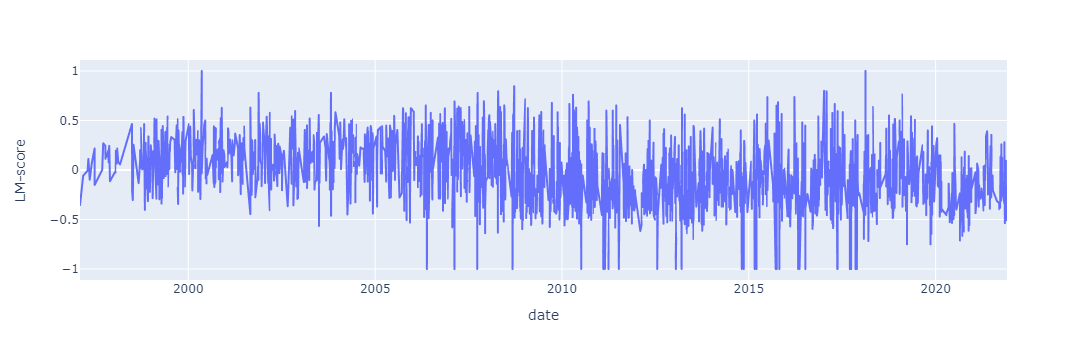

In [76]:

fig=df.plot(x="date",y="LM-score",backend='plotly')
fig.show()
#peu lisible

<AxesSubplot:xlabel='Year,Month'>

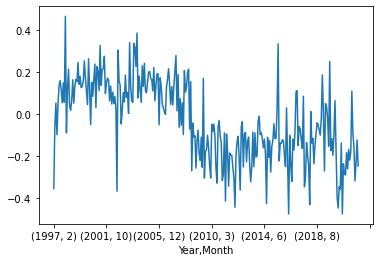

In [77]:
df1=df.groupby(["Year","Month"]).mean()
df1["LM-score"].plot()
#une tendance se dégage

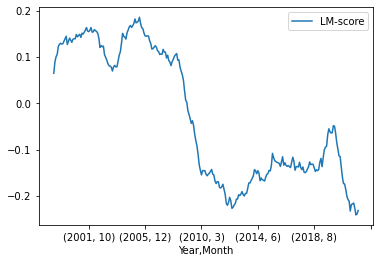

In [81]:
df2=df1.rolling(20).mean() #moyenne mobile sur 20 mois
fig=df2.plot(y="LM-score")


In [79]:
df.rolling(20, on="date").mean() #moyenne mobile sur 20 jours

,date,Day,DayofWeek,LM-score,Month,Year
0,2021-11-29,NaN,NaN,NaN,NaN,NaN
1,2021-11-26,NaN,NaN,NaN,NaN,NaN
2,2021-11-25,NaN,NaN,NaN,NaN,NaN
3,2021-11-24,NaN,NaN,NaN,NaN,NaN
4,2021-11-22,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2325,1997-05-13,17.65,3.05,0.098085,7.10,1997.25
2326,1997-04-30,18.90,3.00,0.092770,7.20,1997.20
2327,1997-04-22,18.50,2.85,0.089275,7.35,1997.15
2328,1997-03-10,17.90,2.70,0.076590,7.45,1997.10


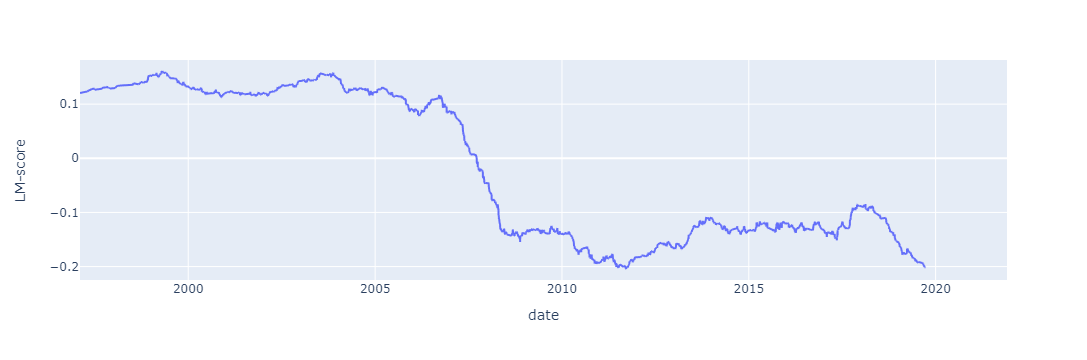

In [85]:
fig=df.rolling(200, on="date").mean().plot(x="date",y="LM-score",backend='plotly')
fig.show()

## Dataset "financial_phrasebank"

In [15]:
#!pip install datasets

In [18]:
import datasets

dataset = datasets.load_dataset("financial_phrasebank", 'sentences_allagree')

Downloading:   0%|          | 0.00/682k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

Dataset financial_phrasebank downloaded and prepared to C:\Users\Antoine\.cache\huggingface\datasets\financial_phrasebank\sentences_allagree\1.0.0\a6d468761d4e0c8ae215c77367e1092bead39deb08fbf4bffd7c0a6991febbf0. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
pd.DataFrame.from_dict(dataset)

,train
0,"{'sentence': 'According to Gran , the company ..."
1,"{'sentence': 'For the last quarter of 2010 , C..."
2,"{'sentence': 'In the third quarter of 2010 , n..."
3,{'sentence': 'Operating profit rose to EUR 13....
4,{'sentence': 'Operating profit totalled EUR 21...
...,...
2259,{'sentence': 'Operating result for the 12-mont...
2260,{'sentence': 'HELSINKI Thomson Financial - Sha...
2261,{'sentence': 'LONDON MarketWatch -- Share pric...
2262,{'sentence': 'Operating profit fell to EUR 35....
